In [1]:
import nibabel as nib
%pylab
%matplotlib inline
import torch
from torch.nn import functional as F

Using matplotlib backend: <object object at 0x7fa80a752460>
Populating the interactive namespace from numpy and matplotlib


In [2]:
from matplotlib.collections import LineCollection

def plot_grid(x, y, ax=None, **kwargs):
    ax = ax or plt.gca()
    segs1 = np.stack((x,y), axis=2)
    segs2 = segs1.transpose(1,0,2)
    ax.add_collection(LineCollection(segs1, **kwargs))
    ax.add_collection(LineCollection(segs2, **kwargs))
    ax.autoscale()

In [3]:
def detJac(vx, vy):
    vx_y, vx_x = np.gradient(vx)
    vy_y, vy_x = np.gradient(vy)
    det = vx_x*vy_y - vx_y*vy_x
    return det[1:-1, 1:-1]

In [4]:
!mkdir -p supp

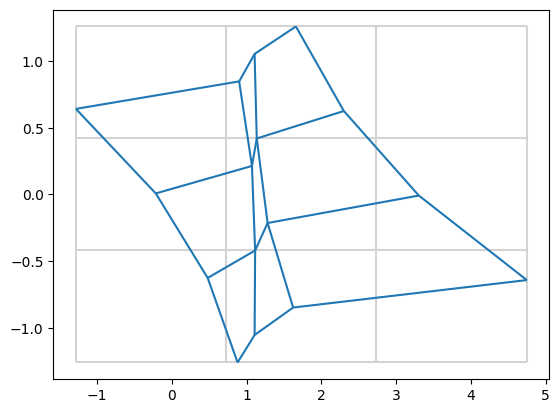

In [13]:
N = 4
x, y = np.linspace(-1, 1, N), np.linspace(-1, 1, N)
xx, yy = np.meshgrid(x, y)
# vx = xx + 5 * xx**3 #0.2*(xx**2 - yy**2) + 0.1*xx**3 + xx
# vy = yy - 2*xx# - 0.25*xx*yy**3
# x1 = 1.5*(xx + 1)
# vx = -2 + 10.9*x1 - 11.3*x1**2 + 3*x1**3
# vy = yy - 0.01*xx

# vx = (xx > 0)*(np.abs(xx)**3) + (xx < 0)*(0.1*xx)
# vy = yy - 0.1*xx**2
# vx = xx + 0.8 * (1.1 + xx) * yy**3# + 0.325*xx**4 #+ 0.2*np.sin((1 + yy) * np.pi/2)  # 1 * np.sqrt(np.abs(np.sin(xx * np.pi / 2)))
# vy = yy - xx**3# - 0.325*yy**4
x1, y1 = xx, yy
# theta = np.pi/2 - np.pi/20
theta = np.pi/10
x1, y1 = np.cos(theta)*x1 - np.sin(theta)*y1, np.sin(theta)*x1 + np.cos(theta)*y1
x1 = (x1 + 1)*0.5 * 3
# rotate the axes
# x1, y1 = x1 - y1, y1 + x1
# vx = 4.83333*x1 - 5.35*x1**2 + 1.6167*x1**3
vx = 2.5*x1 - 1.85*x1**2 + 0.45*x1**3
vy = y1 
# these are the new x and y
# vx, vy = vx + vy, vx - vy
# maxmag = np.max(np.sqrt(np.maximum(vx**2, vy**2)))
xmin, xmax = np.min(vx), np.max(vx)
ymin, ymax = np.min(vy), np.max(vy)
plot_grid(((xx + 1)*0.5)*(xmax-xmin)+xmin, ((yy + 1)*0.5)*(ymax -ymin) +ymin, color='lightgray')
plot_grid(vx, vy, color='C0')
plt.savefig("supp/diffeo_init.pdf", bbox_inches='tight')

In [519]:
print((detJac(vx, vy)<=0).mean())

0.0


In [520]:
# bilinear interpolation
phi = torch.stack((torch.from_numpy(vx).float(), torch.from_numpy(vy).float()), dim=-1)
phi = phi[None].permute(0, 3, 1, 2)
phi_bilinear = F.interpolate(phi, scale_factor=8, mode='bilinear', align_corners=True)
phi_bicubic = F.interpolate(phi, scale_factor=8, mode='bicubic', align_corners=True)

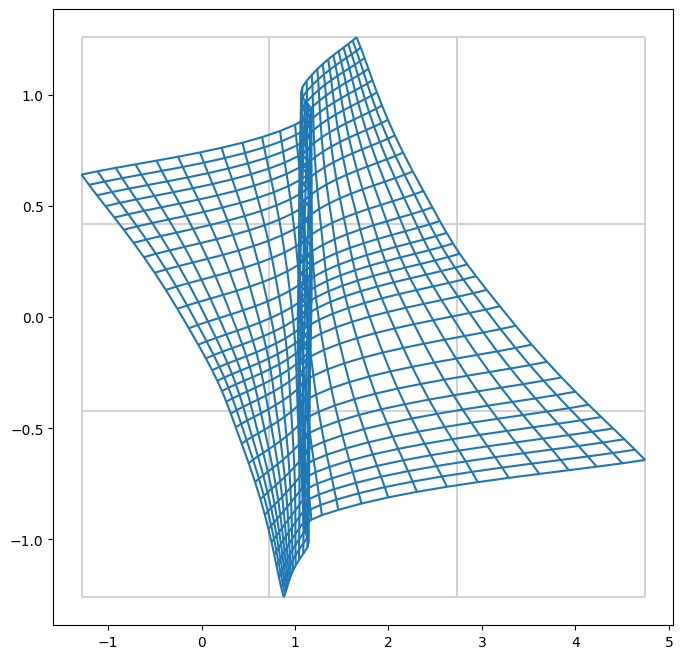

In [528]:
plt.figure(figsize=(8, 8))
vx_c = phi_bicubic[0, 0].numpy()
vy_c = phi_bicubic[0, 1].numpy()
# maxmag = np.max(np.sqrt(np.maximum(vx**2, vy**2)))
xmin, xmax = np.min(vx_c), np.max(vx_c)
ymin, ymax = np.min(vy_c), np.max(vy_c)
plot_grid(((xx + 1)*0.5)*(xmax-xmin)+xmin, ((yy + 1)*0.5)*(ymax -ymin) +ymin, color='lightgray')
plot_grid(vx_c, vy_c, color='C0')
plt.savefig("supp/warp_cubic.pdf", bbox_inches='tight')

0.16444444444444445


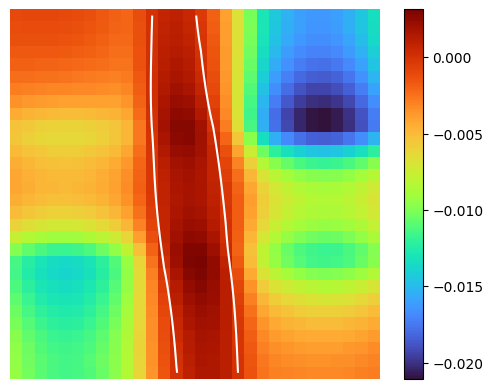

In [529]:
print((detJac(vx_c, vy_c)<=0).mean())
plt.imshow(-detJac(vx_c, vy_c), cmap='turbo',); plt.colorbar(); plt.axis('off')
plt.contour(-detJac(vx_c, vy_c), levels=[0], colors='white')
plt.savefig("supp/detJac_cubic.pdf", bbox_inches='tight')

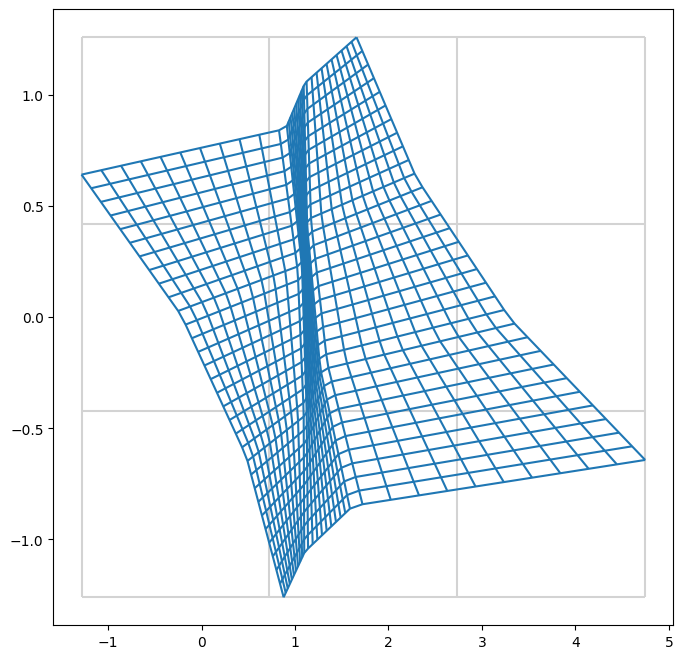

In [530]:
plt.figure(figsize=(8, 8))
vx_c = phi_bilinear[0, 0].numpy()
vy_c = phi_bilinear[0, 1].numpy()
# maxmag = np.max(np.sqrt(np.maximum(vx**2, vy**2)))
xmin, xmax = np.min(vx_c), np.max(vx_c)
ymin, ymax = np.min(vy_c), np.max(vy_c)
plot_grid(((xx + 1)*0.5)*(xmax-xmin)+xmin, ((yy + 1)*0.5)*(ymax -ymin) +ymin, color='lightgray')
plot_grid(vx_c, vy_c, color='C0')
plt.savefig("supp/warp_bilinear.pdf", bbox_inches='tight')

0.0


/home/rohitrango/data/miniconda3/envs/cudants/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: No contour levels were found within the data range.
  This is separate from the ipykernel package so we can avoid doing imports until


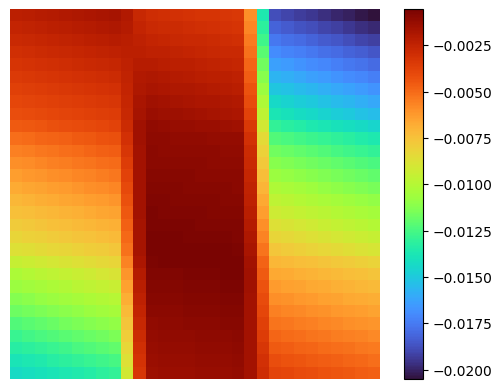

In [531]:
print((detJac(vx_c, vy_c)<=0).mean())
plt.imshow(-detJac(vx_c, vy_c), cmap='turbo', ); plt.colorbar(); plt.axis('off')
plt.contour(-detJac(vx_c, vy_c), levels=[0], colors='white')
plt.savefig("supp/detJac_bilinear.pdf", bbox_inches='tight')

## Plot for Riemannian manifold

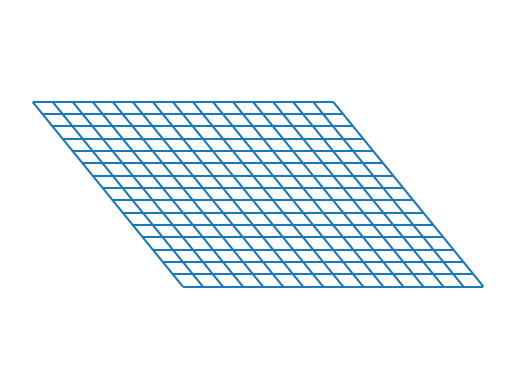

In [20]:
N = 16
x, y = np.linspace(-1, 1, N), np.linspace(-1, 1, N)
xx, yy = np.meshgrid(x, y)
vx = xx - 0.5 * yy
vy = yy / 2
# these are the new x and y
# vx, vy = vx + vy, vx - vy
# maxmag = np.max(np.sqrt(np.maximum(vx**2, vy**2)))
xmin, xmax = np.min(vx), np.max(vx)
ymin, ymax = np.min(vy), np.max(vy)
# plot_grid(((xx + 1)*0.5)*(xmax-xmin)+xmin, ((yy + 1)*0.5)*(ymax -ymin) +ymin, color='lightgray')
plot_grid(vx, vy, color='C0')
plt.axis('off')
plt.ylim(-1, 1)
plt.savefig("supp/vector_grid.svg", bbox_inches='tight')

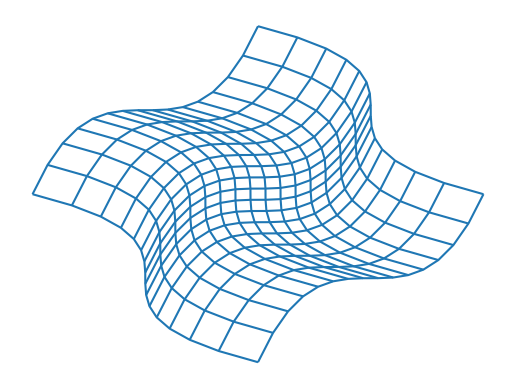

In [23]:
N = 16
x, y = np.linspace(-1, 1, N), np.linspace(-1, 1, N)
xx, yy = np.meshgrid(x, y)
vx = xx - yy**3
vy = yy + xx**3
# these are the new x and y
# vx, vy = vx + vy, vx - vy
# maxmag = np.max(np.sqrt(np.maximum(vx**2, vy**2)))
xmin, xmax = np.min(vx), np.max(vx)
ymin, ymax = np.min(vy), np.max(vy)
# plot_grid(((xx + 1)*0.5)*(xmax-xmin)+xmin, ((yy + 1)*0.5)*(ymax -ymin) +ymin, color='lightgray')
plot_grid(vx, vy, color='C0')
plt.axis('off')
# plt.ylim(-1, 1)
plt.savefig("supp/rie_grid.svg", bbox_inches='tight')